## Semi supervised Learning
Author: Iraitz Azcarate

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from ipywidgets import interact
from scipy.stats import multivariate_normal


Para esta practica, vamos a emplear la funcion 'make_classification' del modulo datasets de sklearn para generar los datos. Con ellos, generaremos conjuntos de datos con estructura de cluster, eliminaremos ciertas etiquetas e intentaremos generar un modelo de clasificación haciendo uso no solo de los datos con etiquetas, sino con todo el conjunto de datos.

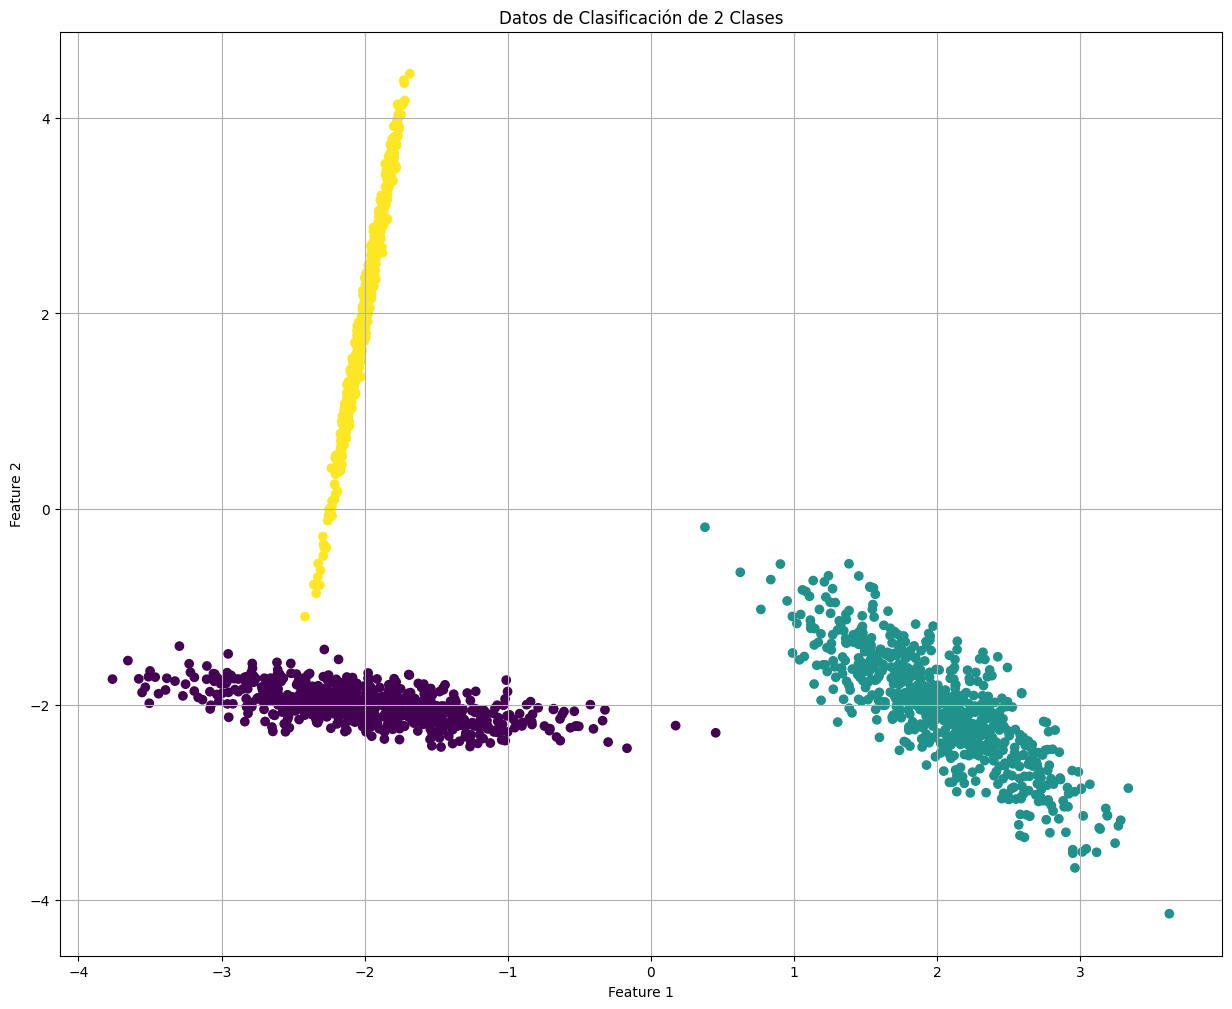

In [2]:
X, y = make_classification(n_samples=2000, n_features=2, n_informative=2, 
                            n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                            class_sep=2.0, flip_y=0, random_state=20)

plt.figure(figsize=(15, 12)) 
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Datos de Clasificación de 2 Clases')
plt.grid()
plt.show()

# Tecnica 1: Self  training

Esta tecnica consiste en generar un clasificador con los datos etiquetados. Luego, con este modelo, se clasifican los datos sin etiquetar y se toman las k-predicciones más fiables como nuevas etiquetas. Finalmente, estos nuevos datos etiquetados se unen a los datos etiquetados y se vuelve a entrenar el modelo. Este proceso se repite, en general, hasta que no se clasifican puntos con una probabilidad suficientemente alta como para considerarlos como etiquetados.

Aplicamos el modelo a nuestros datos. En este caso, el clasificador supervisado que hemos elegido es el 'Random Forest'.

Accuracy del modelo de Self-Training: 1.0000


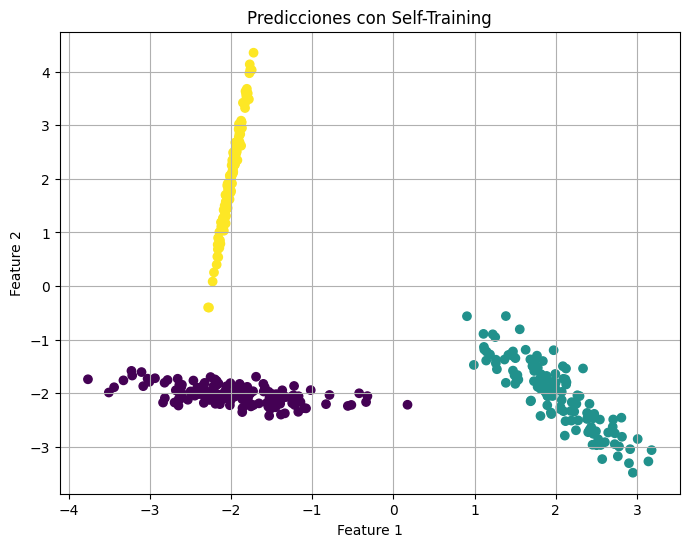

In [3]:

#Divido los datos en datos de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#La mitad de los datos de entrenamiento los tomo como unlabeled. Borro etiquetas
y_train[800:] = -1 

# Creo el modelo de Self-Training usando un clasificador base, en este caso RandomForest
base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
self_training_model = SelfTrainingClassifier(base_classifier)

# Entreno el modelo con los datos de entrenamiento
self_training_model.fit(X_train, y_train)

# Predecir en el conjunto de test
y_pred = self_training_model.predict(X_test)

# Mido el accuracy del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy del modelo de Self-Training: {accuracy:.4f}")

# Visualización de los datos y las predicciones
plt.figure(figsize=(8, 6))
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred,)
plt.title('Predicciones con Self-Training')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid()

Como vemos, el algoritmo clasifica el 100% de los puntos correctamente. Esto se debe a que hemos empleado una base de datos donde los grupos estan perfectamente definidos y distanciados. Si la distancia entre los grupos se reduce, el clasificador tendra mas porblemas para distinguir los grupos.

In [ ]:
def update_plot(class_sep):
    X, y = make_classification(n_samples=2000, n_features=2, n_informative=2, 
                            n_redundant=0, n_classes=3, n_clusters_per_class=1, 
                            class_sep=class_sep, flip_y=0, random_state=20)

    #Divido los datos en datos de entrenamiento y de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    #La mitad de los datos de entrenamiento los tomo como unlabeled. Borro etiquetas
    y_train[800:] = -1 

    # Creo el modelo de Self-Training usando un clasificador base, en este caso RandomForest
    base_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
    self_training_model = SelfTrainingClassifier(base_classifier)

    # Entreno el modelo con los datos de entrenamiento
    self_training_model.fit(X_train, y_train)

    # Predecir en el conjunto de test
    y_pred = self_training_model.predict(X_test)

    # Mido el accuracy del modelo
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy del modelo de Self-Training: {accuracy:.4f}")

    # Visualización de los datos y las predicciones
    plt.figure(figsize=(8, 6))
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred,)
    plt.title('Predicciones con Self-Training')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.grid()

interact(update_plot,  class_sep =(0.1,10))  # Slider para gamma y nu


interactive(children=(FloatSlider(value=5.05, description='class_sep', max=10.0, min=0.1), Output()), _dom_cla…

<function __main__.update_plot(class_sep)>

# Tecnica 2: Co-Training

Esta tecnica se basa en dividir el conjunto de variables de nuestros datos en dos conjuntos. Luego, se toma el primer grupo de variables y se entrena un modelo clasificador con los datos etiquetados. A continuación, se aplica el modelo a los datos sin etiquetar y los k puntos con mayor probabilidad de pertenencia a una clase se etiquetan. Estos datos se unen a los datos ya etiquetados, formando un nuevo conjunto de datos etiquetados, y pasan a usarse para entrenar el segundo modelo con el segundo conjunto de variables. Todo el procedimiento se repite en este segundo modelo, pasando nuevamente al primero y asi hasta llegar al punto en el que ninguno de los datos se clasifica con una probabilidad suficientemente alta como para etiquetarlo. Ahí finaliza el algoritmo.

In [5]:
#Generamos datos de dimension 10, los cuales forman dos clusters. Debido a su alta dimension, no es posible visualizar los clusteres bien separados.
X, y = make_classification(n_samples=2000, n_features=10, n_informative=10, 
                            n_redundant=0, n_classes=2, n_clusters_per_class=1, 
                            class_sep=2.0, flip_y=0, random_state=20)
print(X.shape)

(2000, 10)


En este caso, no he encontrado una libreria que implemente el metodo Co-training, por lo que lo haremos nosotros.

In [15]:
#Divido los datos en datos de entrenamiento y de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Elimino la etiqueta del 40 porciento de los datos de training
X_label, X_unlabel, y_label, y_unlabel = train_test_split(X_train, y_train, test_size=0.4, random_state=42)
y_unlabel[:] = -1

# Creo los modelos de RandomForest
rf_1 = RandomForestClassifier(n_estimators=100, random_state=22)
rf_2 = RandomForestClassifier(n_estimators=100, random_state=42)

#Comienzo del algoritmo
for i in range(200): #maximas iteraticiones = 200

    # Separo el conjunto de variables en dos, 5 variables para cada modelo
    X_label_1, X_label_2 = X_label[:, :5], X_label[:, 5:]
    X_unlabel_1, X_unlabel_2 = X_unlabel[:, :5], X_unlabel[:, 5:]

    # Entreno el modelo con los datos de entrenamiento
    if i % 2 == 0:
        rf_1.fit(X_label_1, y_label)
        y_pred = rf_1.predict_proba(X_unlabel_1)
    else:
        rf_2.fit(X_label_2, y_label)
        y_pred = rf_2.predict_proba(X_unlabel_2)
    
    # Recojo las psudoetiquetas cuya probabilidad de pertenecer a una clase supera el 95%.
    Mejoria=False
    unos, ceros = [], []
    for j in range(len(y_pred)):
        if y_pred[j][0] > 0.95:
            Mejoria=True
            unos.append(j)
        elif y_pred[j][0] < 0.05:
            Mejoria=True
            ceros.append(j)

    # En el caso de que ningun valor se halla clasificado con una probabilidad suficientemente alta, se para el algoritmo
    if not Mejoria:
        break

    #Si hay valores con probabilidad mayor a 95%, convierto las pseudoetiquetas en etiquetas reales y muevo el dato de 'unlabeled' a 'labelled'
    indices = unos + ceros
    X_label = np.vstack([X_label, X_unlabel[indices]])  # Añadir las filas seleccionadas de X_unlabel a X_label
    y_label = np.append(y_label, np.ones(len(unos)))  # Añadir etiquetas correspondientes a y_label
    y_label = np.append(y_label, np.zeros(len(ceros)))  # Añadir etiquetas correspondientes a y_label
    
    X_unlabel = np.delete(X_unlabel, indices, axis=0)  # Eliminar las filas de X_unlabel
    y_unlabel = np.delete(y_unlabel, indices) # Eliminar las filas de y_unlabel
    
#Entreno finalmente ambos modelos con el conjunto final de muestras etiquetadas
rf_1.fit(X_label, y_label)
y_pred_1 = rf_1.predict(X_test)
rf_2.fit(X_label, y_label)
y_pred_2 = rf_2.predict(X_test)

# Mido el accuracy de ambos modelos y calculo la media
accuracy_1 = accuracy_score(y_test, y_pred_1)
accuracy_2 = accuracy_score(y_test, y_pred_2)
accuracy = np.mean([accuracy_1,accuracy_2])
print(f"Accuracy del modelo de Co-Training: {accuracy:.4f}")


Accuracy del modelo de Co-Training: 0.8313


El modelo clasifica correctamente el 83% de las muestras, lo cual representa un desempeño aceptable pero con margen para mejorar. Para incrementar la precisión, se podrían explorar las siguientes estrategias:

* Optimización de los parámetros de los algoritmos supervisados.

* Ajuste del umbral de confianza para las pseudoetiquetas (actualmente 0.95 y 0.05).

* Asegurar que el conjunto de datos etiquetados conserve un balance proporcional entre las clases. 


## Tecnica 3: Gaussian Model - Expectation + Maximization (EM)

Este ultimo algoritmo que vamos a estudiar supone que los datos de nuestra muestra provienen de distribuciones normales multivariables. Por ello, vamos a generar los datos a partir de dos distribuciones normales, con la esperanza de obtener un modelo clasificador bueno

In [16]:
#Gaussiana 1
mean1 = [2, 3]  
cov1 = [[1, 0.5], [0.5, 1]] 
n1 = 500  

#Gaussiana 2
mean2 = [5, 7]  
cov2 = [[3, -0.3], [-0.3, 2]]  
n2 = 500 

# Generar puntos
data1 = np.random.multivariate_normal(mean1, cov1, n1)
data2 = np.random.multivariate_normal(mean2, cov2, n2)
colors = {0: 'blue', 1: 'red'}

# Etiquetas
labels1 = np.zeros((n1, 1))  # Pertenecen a la primera gaussiana
labels2 = np.ones((n2, 1))   # Pertenecen a la segunda gaussiana

# Creamos los datasets de training y tests
data1_with_labels = np.hstack((data1, labels1))
data2_with_labels = np.hstack((data2, labels2))
dataset = np.vstack((data1_with_labels, data2_with_labels))
df = pd.DataFrame(dataset, columns=["x1", "x2", "c"])
df, df_test = train_test_split(df, test_size=100, random_state=42)


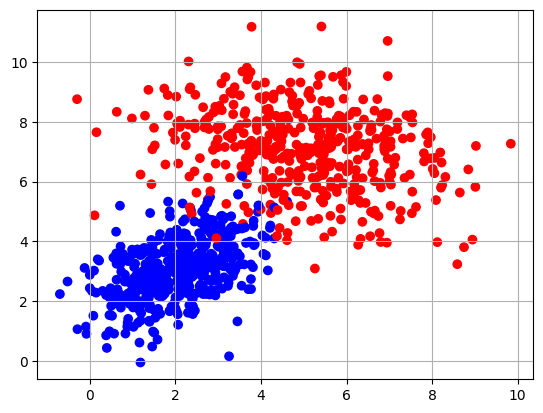

In [17]:
plt.scatter(df['x1'], df['x2'], c=df['c'].map(colors))
plt.grid()

Vemos que ambas distribuciones se distinguen bien, aunque existe una zona donde quizá sea más complicado identificar la distribucion de la que proviene cada punto.

Como se trata de una tecnica de clasificación semi-supervisada, eliminamos algunas de las etiquetas de nuestros datos de training

In [18]:
#Elimino ciertas etiquetas:
df.loc[df.index[-50:], 'c'] = np.nan
# df = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Genero la columna de psudoetiquetas 
df['pseudo_c_2'] = df['c'] #probabilidades de pertenecer a la clase 2.
df['pseudo_c_1'] = 1- df['c'] #probabilidades de pertenecer a la clase 1.

In [19]:
def matriz_var_cov_ponderadas(df, clase = 2):
    '''    
    Esta funcion toma como argumento nuestra tabla de datos y la distribucion y genera la matriz de varianzas/covarianzas correspondiente'''
    
    if clase ==1:
        # Calcular medias ponderadas para x1 y x2
        media_x1 = np.average(df['x1'], weights=df['pseudo_c_1'])
        media_x2 = np.average(df['x2'], weights=df['pseudo_c_1'])
        # Calcular la varianza ponderada para x1 y x2
        var_x1 = np.average((df['x1'] - media_x1)**2, weights=df['pseudo_c_1'])
        var_x2 = np.average((df['x2'] - media_x2)**2, weights=df['pseudo_c_1'])
        # Calcular la covarianza ponderada entre x1 y x2
        cov_x1_x2 = np.average((df['x1'] - media_x1) * (df['x2'] - media_x2), weights=df['pseudo_c_1'])

        return np.array([[var_x1, cov_x1_x2],
                            [cov_x1_x2, var_x2]])
    else:
        media_x1 = np.average(df['x1'], weights=df['pseudo_c_2'])
        media_x2 = np.average(df['x2'], weights=df['pseudo_c_2'])
        var_x1 = np.average((df['x1'] - media_x1)**2, weights=df['pseudo_c_2'])
        var_x2 = np.average((df['x2'] - media_x2)**2, weights=df['pseudo_c_2'])
        cov_x1_x2 = np.average((df['x1'] - media_x1) * (df['x2'] - media_x2), weights=df['pseudo_c_2'])

        return np.array([[var_x1, cov_x1_x2],
                            [cov_x1_x2, var_x2]])

    

A continuacion, iteramos un numero limitado de veces para ir ajustando en cada iteracion tanto los parametros de las distribuciones como las pseudoetiquetas. 

In [20]:

#primera iteraccion, sin pseudoetiquetas aun para la muestra no etiquetada
df_pre = df.dropna()
#Calculamos los pesos de cada distribucion
w2 = np.sum(df_pre['pseudo_c_2'])/len(df_pre)
w1 = np.sum(df_pre['pseudo_c_1'])/len(df_pre)
#Calculamos las medias
u11,u12 = np.average(df_pre['x1'], weights=df_pre['pseudo_c_1']), np.average(df_pre['x2'], weights=df_pre['pseudo_c_1'])
u21,u22 = np.average(df_pre['x1'], weights=df_pre['pseudo_c_2']), np.average(df_pre['x2'], weights=df_pre['pseudo_c_2'])
#Calculamos las matrices de covarianzas
s1 = matriz_var_cov_ponderadas(df_pre, clase = 1)
s2 = matriz_var_cov_ponderadas(df_pre, clase = 2)

#Asignamos las probabilidades de pertenencia a cada clase a todos los elementos no etiquetados de la muestra
x = df.iloc[-50:, :2].values
pdf_value_1 = w1 * multivariate_normal.pdf(x, mean=(u11,u12), cov=s1)
pdf_value_2 = w2 * multivariate_normal.pdf(x, mean=(u21,u22), cov=s2)
suma = pdf_value_1+pdf_value_2
pdf_value_1 = pdf_value_1/suma
pdf_value_2 = pdf_value_2/suma
df.iloc[-50:, df.columns.get_loc('pseudo_c_1')] = pdf_value_1
df.iloc[-50:, df.columns.get_loc('pseudo_c_2')] = pdf_value_2

#Repetimos el mismo proceso un numero finito de veces, ya con psudoetiquetas para los valores no etiquetados
for i in range(20):
    w2 = np.sum(df['pseudo_c_2'])/len(df)
    w1 = np.sum(df['pseudo_c_1'])/len(df)
    u11,u12 = np.average(df['x1'], weights=df['pseudo_c_1']), np.average(df['x2'], weights=df['pseudo_c_1'])
    u21,u22 = np.average(df['x1'], weights=df['pseudo_c_2']), np.average(df['x2'], weights=df['pseudo_c_2'])
    s1 = matriz_var_cov_ponderadas(df, clase = 1)
    s2 = matriz_var_cov_ponderadas(df, clase = 2)

    x = df.iloc[-50:, :2].values
    pdf_value_1 = w1 * multivariate_normal.pdf(x, mean=(u11,u12), cov=s1)
    pdf_value_2 = w2 * multivariate_normal.pdf(x, mean=(u21,u22), cov=s2)
    suma = pdf_value_1+pdf_value_2
    df.iloc[-50:, df.columns.get_loc('pseudo_c_1')] = pdf_value_1/suma
    df.iloc[-50:, df.columns.get_loc('pseudo_c_2')] = pdf_value_2/suma



Una vez iterado lo suficiente, tomamos como etiquetas reales aquellas con una probabilidad alta de pertenecer a una de las dos distribuciones

In [21]:
df.loc[df['pseudo_c_2'] > 0.75, 'c'] = 1
df.loc[df['pseudo_c_1'] > 0.75, 'c'] = 0

Finalmente, testeamos con los datos de test

In [22]:
df_train = df[df['c'].notnull()]
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(df_train[['x1','x2']], df_train['c'])
y_pred = model.predict(df_test[['x1','x2']])
print("Accuracy:", accuracy_score(df_test['c'], y_pred))


Accuracy: 0.98


Como vemos, el modelo tiene una precision muy alta

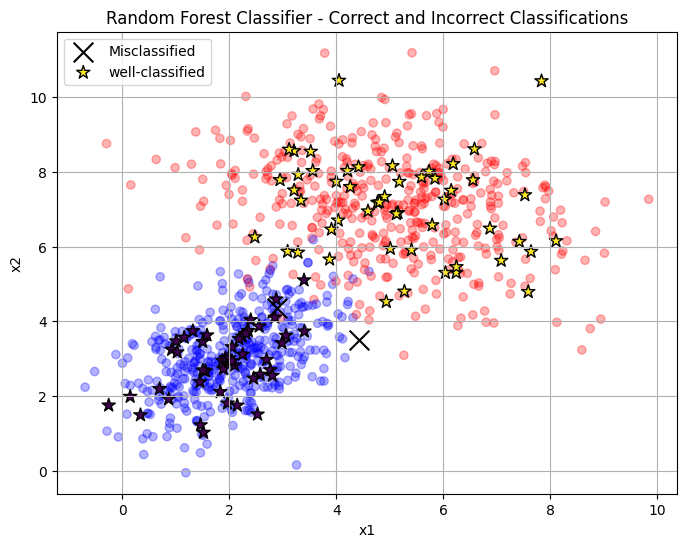

In [23]:
# Gráfico de dispersión
plt.figure(figsize=(8, 6))

# Puntos correctamente clasificados (colorear por clase)
plt.scatter(df_pre['x1'], df_pre['x2'],  c=df_pre['c'].map(colors), alpha=0.3)

# Puntos mal clasificados (marcar con cruz)
incorrectly_classified = df_test[y_pred != df_test['c']]
correctly_classified = df_test[y_pred == df_test['c']]
plt.scatter(incorrectly_classified['x1'], incorrectly_classified['x2'], c='black', marker='x', s=200,label='Misclassified')
plt.scatter(correctly_classified['x1'], correctly_classified['x2'], c=correctly_classified['c'], marker='*', edgecolors='black', s=100, label='well-classified')

# Etiquetas y título
plt.title('Random Forest Classifier - Correct and Incorrect Classifications')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()

# Mostrar el gráfico
plt.grid()
plt.show()